In [1]:
import requests
import re
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys

sys.path.append('/path/to/module')
import googlemaps
import geopandas as gpd
import requests
import json
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import shapely
import folium
import contextily as ctx
from shapely.geometry import Point
from datetime import date

current_date = date.today().strftime('%Y-%m-%d')

## Get and read in data

In [2]:
city = 'fargo'
state = 'nd'
%run zillow_data_scrape.py fargo nd

Scraping data...
Error: The City or State entered could not be found.


In [3]:
city = 'west fargo'
state = 'nd'
%run zillow_data_scrape.py west-fargo nd

Scraping data...
Done.
West-fargo_Homes_ForSale_2023-05-20.csv is available for viewing.
West-fargo_Apartments_ForRental_2023-05-20.csv is available for viewing.


In [4]:
city = 'moorhead'
state = 'mn'
%run zillow_data_scrape.py Moorhead mn

Scraping data...
Error: The City or State entered could not be found.


In [5]:
#Read in data and combine into one data frame
city = 'Fargo-Moorhead'

Home_file1 = pd.read_csv("./data/Fargo_Homes_ForSale_"+current_date+".csv")
Home_file2 = pd.read_csv("./data/Moorhead_Homes_ForSale_"+current_date+".csv")
Home_file3 = pd.read_csv("./data/West-fargo_Homes_ForSale_"+current_date+".csv")

df = Home_file1.append([Home_file2, Home_file3])

apt_file1 = pd.read_csv("./data/Fargo_Apartments_ForRental_"+current_date+".csv")
apt_file2 = pd.read_csv("./data/Moorhead_Apartments_ForRental_"+current_date+".csv")
apt_file3 = pd.read_csv("./data/West-fargo_Apartments_ForRental_"+current_date+".csv")

df2 = apt_file1.append([apt_file2, apt_file3])

In [6]:
#Use googlemaps api to convert addresses to coordinates 
#(you'll need to obtain an api key to make this work, otherwise comment it out)

with open('credentials.json') as f:
    credentials = json.load(f)

api_key = credentials['googlemaps'] 
    
def get_lat_long(address, api_key):
    base_url = "https://maps.googleapis.com/maps/api/geocode/json?"
    params = {
        "key": api_key,
        "address": address
    }
    
    response = requests.get(base_url, params=params).json()
    if response["status"] == "OK":
        lat = response["results"][0]["geometry"]["location"]["lat"]
        long = response["results"][0]["geometry"]["location"]["lng"]
        return lat, long
    else:
        return None, None

df["lat_long"] = df["address"].apply(lambda x: get_lat_long(x, api_key))
df[["latitude", "longitude"]] = pd.DataFrame(df["lat_long"].tolist(), index=df.index)
df = df.drop("lat_long", axis=1)

df2["lat_long"] = df2["address"].apply(lambda x: get_lat_long(x, api_key))
df2[["latitude", "longitude"]] = pd.DataFrame(df2["lat_long"].tolist(), index=df2.index)
df2 = df2.drop("lat_long", axis=1)

#drop coordinates that are not anywhere near our city
df = df.drop(df[(df['latitude'] > 47) | (df['latitude'] < 46) | (df['longitude'] > -96) | (df['longitude'] < -97)].index)
df2 = df2.drop(df2[(df2['latitude'] > 47) | (df2['latitude'] < 46) | (df2['longitude'] > -96) | (df2['longitude'] < -97)].index)

## Homes

Warning 1: +init=epsg:XXXX syntax is deprecated. It might return a CRS with a non-EPSG compliant axis order.


Total Number of Houses Available for sale in Fargo-Moorhead: 748


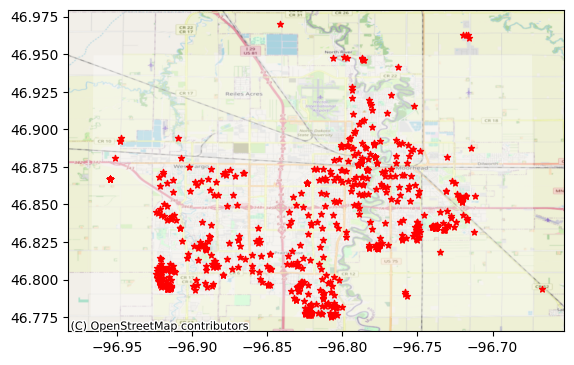

In [7]:
#Plot a map of Houses available
geometry = [Point(xy) for xy in zip(df['longitude'],df['latitude'])]

wardlink = "./geodata/Fargo-Moorhead_Area-polygon.shp"

ward = gpd.read_file(wardlink, bbox=None, mask=None, rows=None)
geo_df = gpd.GeoDataFrame(geometry = geometry)

ward.crs = {'init':"epsg:4326"}
geo_df.crs = {'init':"epsg:4326"}

ax = ward.plot(alpha=0.35, color='#ffffff', zorder=1)
ax = geo_df.plot(ax = ax, markersize = 20, color = 'red',marker = '*',label = 'Fargo', zorder=3)
ctx.add_basemap(ax, crs=geo_df.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
print("Total Number of Houses Available for sale in "+city+": "+str(len(df)))
plt.show()

### Average

In [8]:
# calculate mean and media house
home_averages = df.copy()

num_cols = home_averages.select_dtypes(include=['int', 'float']).drop(['zpid', 'addressZipcode'], axis=1)

home_averages = pd.DataFrame({
    'mean': num_cols.mean(),
    'median': num_cols.median(),
}).transpose()

home_averages = home_averages.round(decimals = 2)
home_averages = home_averages[['unformattedPrice', 'zestimate', 'best_deal', 'beds', 'baths', 'area']]
home_averages = home_averages.tail(3)

# format value columns with dollar sign and commas
home_averages['unformattedPrice'] = home_averages['unformattedPrice'].replace('[\$\,\.]', '', regex=True).astype(int)
home_averages['zestimate'] = home_averages['zestimate'].replace('[\$\,\.]', '', regex=True).astype(int)
home_averages['unformattedPrice'] = home_averages['unformattedPrice'].apply(lambda x: "${:,.2f}".format(x))
home_averages['zestimate'] = home_averages['zestimate'].apply(lambda x: "${:,.2f}".format(x))

home_averages = home_averages.rename(columns={'unformattedPrice': 'price'}) 
print('Statistics on the Average House For Sale in '+ city + ':' )
home_averages

Statistics on the Average House For Sale in Fargo-Moorhead:


,price,zestimate,best_deal,beds,baths,area
mean,"$361,108.00","$238,881.00",122227.36,3.59,2.63,2478.82
median,"$335,995.00","$239,952.00",8564.50,4.00,3.00,2244.00


### Cheapest and most expensive houses available

In [9]:
max_price = df.copy()
max_price = max_price[['unformattedPrice', 'zestimate', 'best_deal', 'beds', 'baths', 'area', 'address']]
max_price = max_price.sort_values("unformattedPrice")

#Drop houses worth 0
zeros = max_price['unformattedPrice'] == 0
max_price = max_price.drop(max_price[zeros].index)

# format value columns with dollar sign and commas
max_price['unformattedPrice'] = max_price['unformattedPrice'].replace('[\$\,\.]', '', regex=True).astype(int)
max_price['zestimate'] = max_price['zestimate'].replace('[\$\,\.]', '', regex=True).astype(int)
max_price['unformattedPrice'] = max_price['unformattedPrice'].apply(lambda x: "${:,.2f}".format(x))
max_price['zestimate'] = max_price['zestimate'].apply(lambda x: "${:,.2f}".format(x))

max_price = max_price.rename(columns={'unformattedPrice': 'price'}) 
max_price = max_price.rename(columns={'best_deal': 'difference'}) 

print("Cheapest House in "+city+":")
max_price.head(1)

Cheapest House in Fargo-Moorhead:


,price,zestimate,difference,beds,baths,area,address
2,"$22,900.00",$0.00,22900,NaN,NaN,NaN,"2521 38th Ave S, Moorhead, MN 56560"


In [10]:
print("Most Expensive House in "+city+":")
max_price.tail(1)

Most Expensive House in Fargo-Moorhead:


,price,zestimate,difference,beds,baths,area,address
220,"$5,120,000.00",$0.00,5120000,NaN,NaN,NaN,"2800 50th Ave S, Moorhead, MN 56560"


### Best and Worst Deals (According to Zillow)

In [11]:
print("Best Deal on A Home in "+city+":")
max_price = max_price.sort_values("difference")
max_price.tail(1)

Best Deal on A Home in Fargo-Moorhead:


,price,zestimate,difference,beds,baths,area,address
220,"$5,120,000.00",$0.00,5120000,NaN,NaN,NaN,"2800 50th Ave S, Moorhead, MN 56560"


In [12]:
print("Worst Deal on A Home in "+city+":")
max_price.head(1)

Worst Deal on A Home in Fargo-Moorhead:


,price,zestimate,difference,beds,baths,area,address
127,"$315,000.00","$322,522.00",-7522,3.0,2.0,2050.0,"6264 56th Ave S, Fargo, ND 58104"


### Histogram of prices

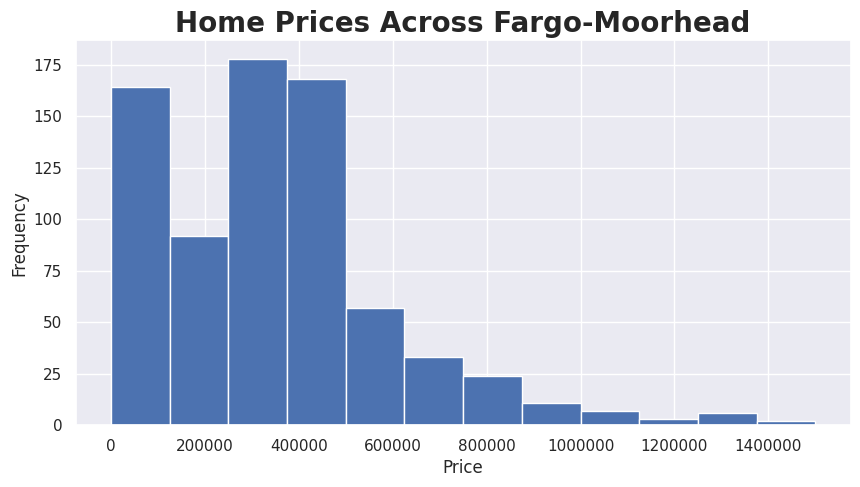

In [13]:
sns.set(rc={"figure.figsize":(10, 5)})
plt.hist(df['unformattedPrice'], bins=12, range={0, 1500000})
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Home Prices Across '+ city, fontdict={'size': 20, 'weight': 'bold'})
plt.ticklabel_format(style='plain', axis="x")
plt.show()

### Pie chart of builders

Note: This chart doesn't include houses where the construction company was unlisted


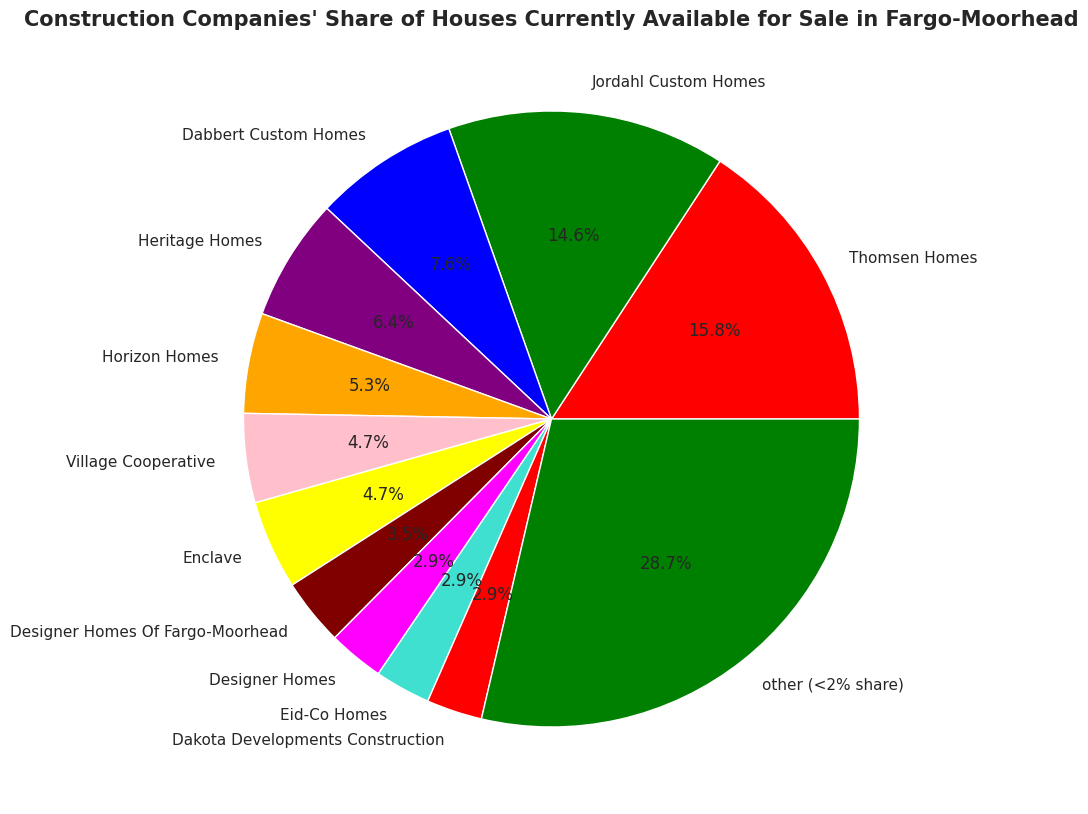

In [14]:
builders = df.copy()

to_replace = [', llc', 'llc', ', inc']
for substring in to_replace:
    builders['builderName'] = builders['builderName'].str.replace(substring, '')

builder_count = builders["builderName"].value_counts()

# create new category that groups builders making up <2% of total
total = builder_count.sum()
threshold = 0.02

builder_percent = builder_count/builder_count.sum()
other_percent = builder_percent[builder_percent < threshold].sum()
builder_percent = builder_percent[builder_percent >= threshold]
builder_percent["other (<2% share)"] = other_percent

builder_percent.plot.pie(figsize=(15, 10), autopct='%1.1f%%', colors=['red', 'green', 'blue', 'purple', 'orange', 'pink', 'yellow', 'maroon', 'magenta', 'turquoise' ])
plt.title("Construction Companies' Share of Houses Currently Available for Sale in Fargo-Moorhead", fontdict={'size': 15, 'weight': 'bold'})
plt.ylabel("")
print("Note: This chart doesn't include houses where the construction company was unlisted")
plt.show()

## Pie chart of brokers

Note: This chart doesn't include houses where the brokerage was unlisted


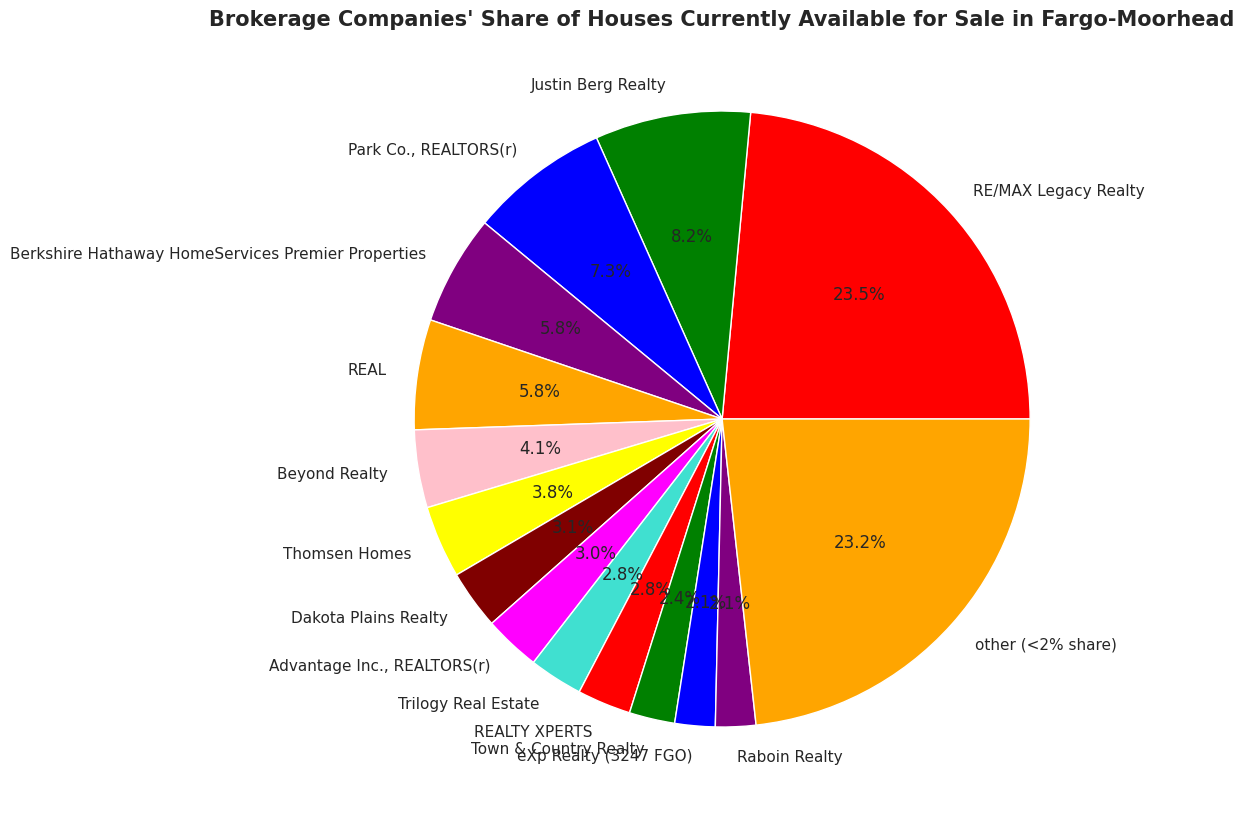

In [15]:
brokers = df.copy()

to_replace = [', llc', 'llc', ', inc']
for substring in to_replace:
    brokers['brokerName'] = brokers['brokerName'].str.replace(substring, '')

broker_count = brokers["brokerName"].value_counts()

# create new category that groups brokers making up <2% of total
total = broker_count.sum()
threshold = 0.02

broker_percent = broker_count/broker_count.sum()
other_percent = broker_percent[broker_percent < threshold].sum()
broker_percent = broker_percent[broker_percent >= threshold]
broker_percent["other (<2% share)"] = other_percent

broker_percent.plot.pie(figsize=(15, 10), autopct='%1.1f%%', colors=['red', 'green', 'blue', 'purple', 'orange', 'pink', 'yellow', 'maroon', 'magenta', 'turquoise' ])
plt.title("Brokerage Companies' Share of Houses Currently Available for Sale in Fargo-Moorhead", fontdict={'size': 15, 'weight': 'bold'})
plt.ylabel("")
print("Note: This chart doesn't include houses where the brokerage was unlisted")
plt.show()

## Beds and Baths

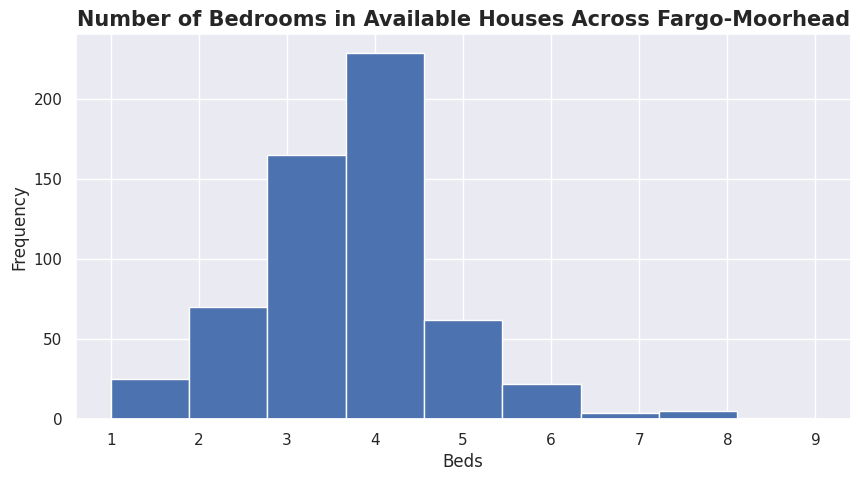

In [16]:
sns.set(rc={"figure.figsize":(10, 5)})
num_beds = int(df['beds'].max())
plt.hist(df['beds'], bins=num_beds)
plt.xlabel('Beds')
plt.ylabel('Frequency')
plt.title('Number of Bedrooms in Available Houses Across '+city, fontdict={'size': 15, 'weight': 'bold'})
plt.show()

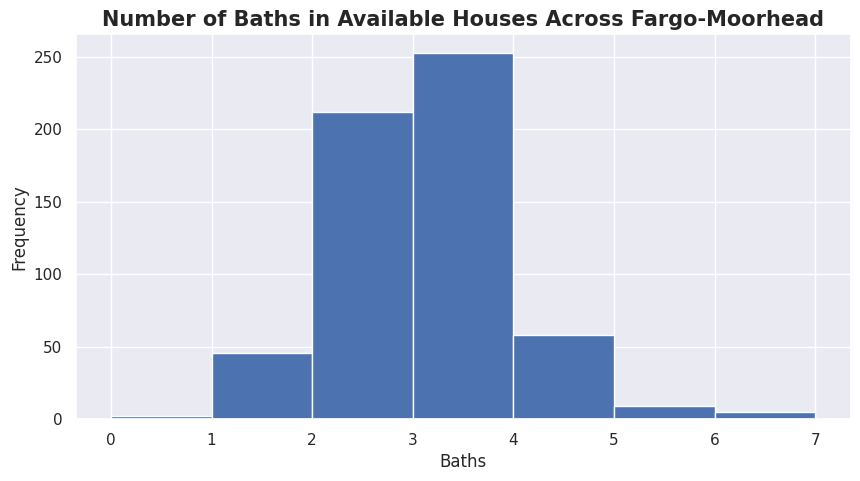

Note: I couldn't get the values to line up with their respective bins. Each value represents the bin to the left.


In [17]:
sns.set(rc={"figure.figsize":(10, 5)})
num_bins = int(df['baths'].max())
plt.hist(df['baths'], bins=num_bins, range={df['baths'].min(), df['baths'].max()})
plt.xlabel('Baths')
plt.ylabel('Frequency')
plt.title('Number of Baths in Available Houses Across '+ city, fontdict={'size': 15, 'weight': 'bold'})
plt.show()
print("Note: I couldn't get the values to line up with their respective bins. Each value represents the bin to the left.")

### Scatter plot comparing Area with Price

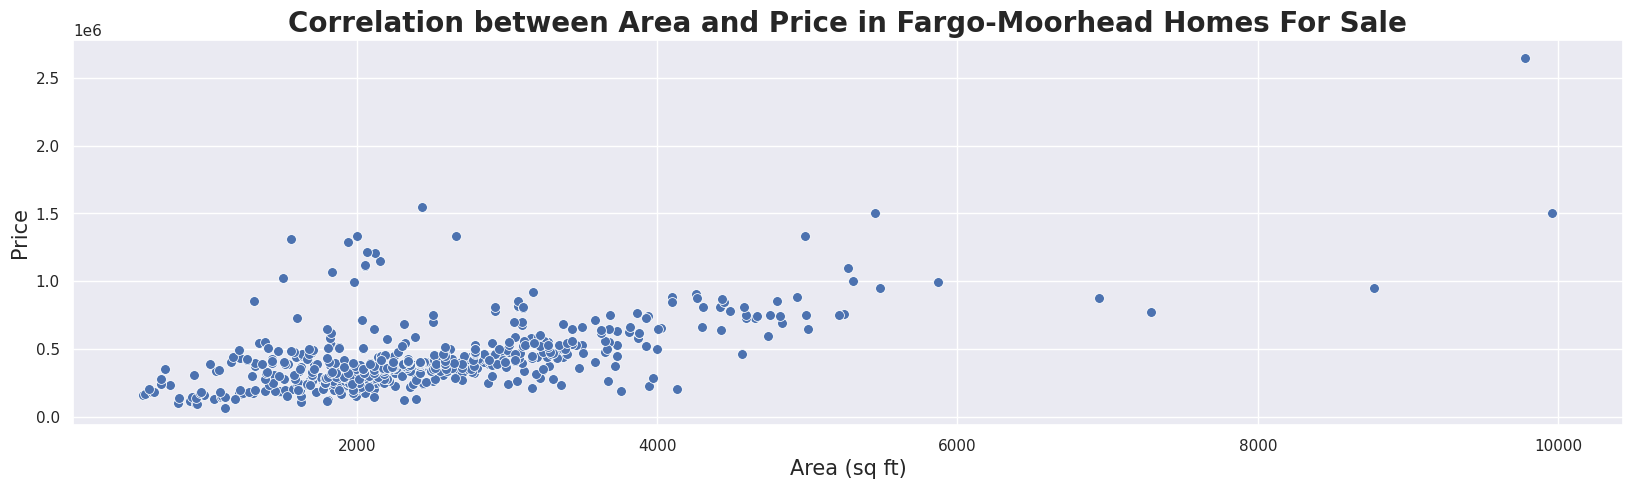

In [18]:
sns.set(rc={"figure.figsize":(20, 5)})
scatter = sns.scatterplot(data=df, x='area', y='unformattedPrice', legend='auto', s=50)
scatter.set_title("Correlation between Area and Price in "+ city + " Homes For Sale", fontdict={'size': 20, 'weight': 'bold'})
scatter.set_xlabel('Area (sq ft)', fontdict={'size': 15})
scatter.set_ylabel('Price', fontdict={'size': 15})
plt.show()

# Apartments

### Visualize Apartment locations

Total Number of apartments available for rental in Fargo-Moorhead: 105


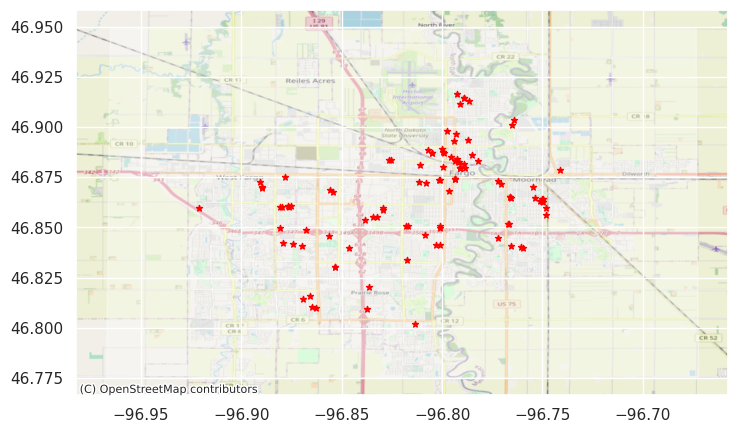

In [19]:
geometry = [Point(xy) for xy in zip(df2['longitude'],df2['latitude'])]

wardlink = "./geodata/Fargo-Moorhead_Area-polygon.shp"

ward = gpd.read_file(wardlink, bbox=None, mask=None, rows=None)
geo_df = gpd.GeoDataFrame(geometry = geometry)

ward.crs = {'init':"epsg:4326"}
geo_df.crs = {'init':"epsg:4326"}
ax = ward.plot(alpha=0.35, color='#ffffff', zorder=1)
ax = geo_df.plot(ax = ax, markersize = 20, color = 'red',marker = '*',label = 'Fargo', zorder=3)

ctx.add_basemap(ax, crs=geo_df.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
print("Total Number of apartments available for rental in "+city+": " +str(len(df2)))
plt.show()

### Averages

In [20]:
apt_averages = df2.copy()

num_cols = apt_averages.select_dtypes(include=['int', 'float']).drop(['addressZipcode'], axis=1)

apt_averages = pd.DataFrame({
    'mean': num_cols.mean(),
    'median': num_cols.median(),
}).transpose()

apt_averages = apt_averages.round(decimals = 2)
apt_averages = apt_averages[['unformattedPrice', 'beds', 'baths', 'area']]
apt_averages = apt_averages.tail(3)

# format value columns with dollar sign and commas
apt_averages['unformattedPrice'] = apt_averages['unformattedPrice'].replace('[\$\,\.]', '', regex=True).astype(int)
apt_averages['unformattedPrice'] = apt_averages['unformattedPrice'].apply(lambda x: "${:,.2f}".format(x))

apt_averages = apt_averages.rename(columns={'unformattedPrice': 'price'})

print('Average Apartment For Rental in '+ city + ': ')
apt_averages

Average Apartment For Rental in Fargo-Moorhead: 


,price,beds,baths,area
mean,$833.00,1.97,1.23,923.62
median,$775.00,2.00,1.00,813.50


### Cheapest and Most Expensive Apartments available

In [21]:
max_price = df2.copy()
max_price = max_price.sort_values("unformattedPrice")
max_price = max_price[['price', 'beds', 'baths', 'area', 'address']]


print("Cheapest Apartment in "+city+":")
max_price.head(1)

Cheapest Apartment in Fargo-Moorhead:


,price,beds,baths,area,address
0,$340.0/mo,NaN,NaN,NaN,"2602 14th St S, Fargo, ND"


In [22]:
print("Most Expensive Apartment in "+city+":")
max_price.tail(1)

Most Expensive Apartment in Fargo-Moorhead:


,price,beds,baths,area,address
70,$1950.0/mo,4.0,2.0,2800.0,"1429 10th St N, Fargo, ND 58102"


### Histogram of price

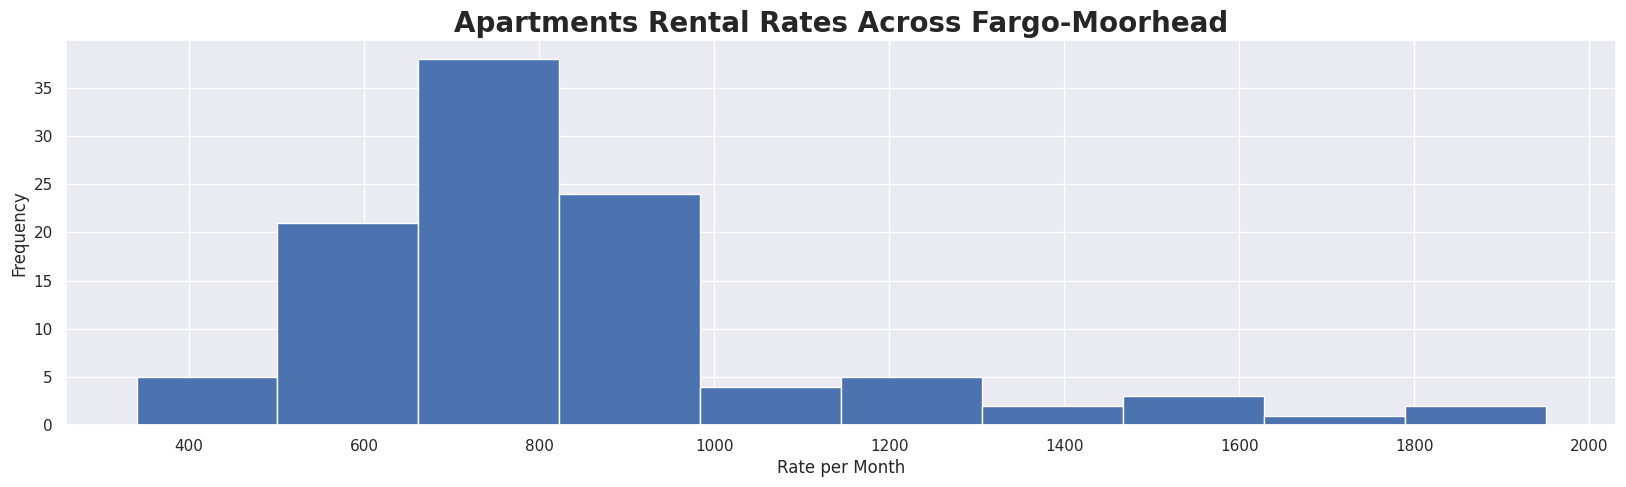

In [23]:
plt.hist(df2['unformattedPrice'])
plt.xlabel('Rate per Month')
plt.ylabel('Frequency')
plt.title('Apartments Rental Rates Across ' + city, fontdict={'size': 20, 'weight': 'bold'})
plt.show()

### Beds, baths, and area

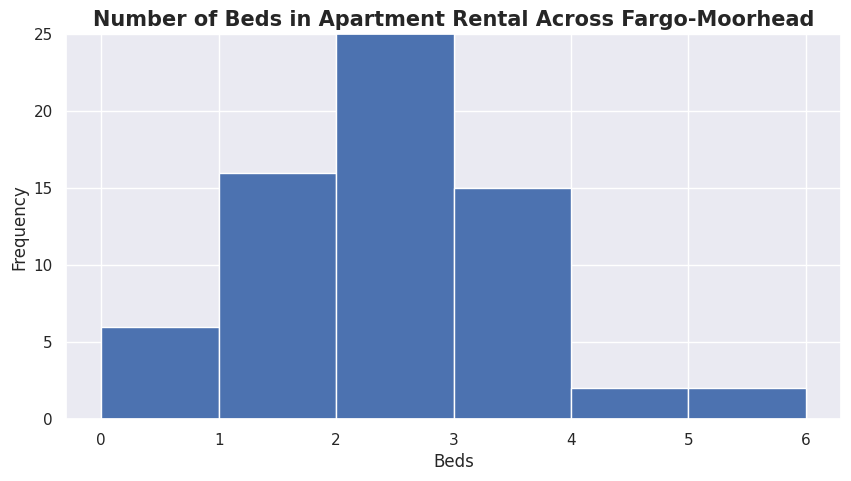

In [24]:
sns.set(rc={"figure.figsize":(10, 5)})
num_bins = int(df2['beds'].max())
plt.hist(df2['beds'], bins=num_bins, range={df2['beds'].max(),df2['beds'].min()})
plt.xlabel('Beds')
plt.ylabel('Frequency')
plt.title('Number of Beds in Apartment Rental Across '+ city, fontdict={'size': 15, 'weight': 'bold'})
plt.ylim(0, 25)
plt.show()

#### Note: I avoided graphing number of bathrooms in apartments because the range was too small

### Scatter plot comparing Area with Price

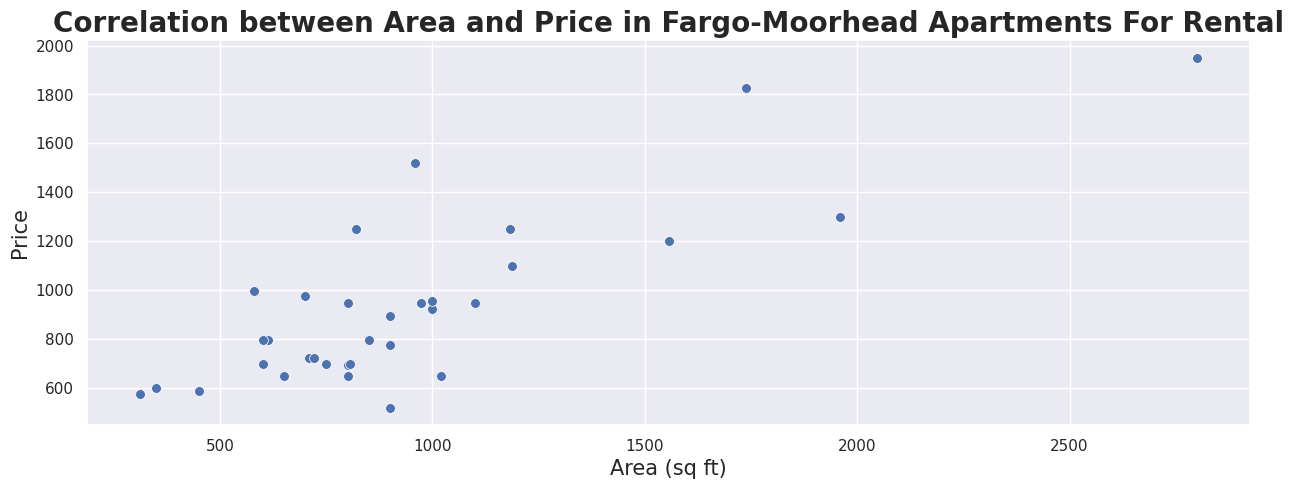

In [25]:
sns.set(rc={"figure.figsize":(15, 5)})
scatter = sns.scatterplot(data=df2, x='area', y='unformattedPrice', legend='auto', s=50)
scatter.set_title("Correlation between Area and Price in "+ city + " Apartments For Rental", fontdict={'size': 20, 'weight': 'bold'})
scatter.set_xlabel('Area (sq ft)', fontdict={'size': 15})
scatter.set_ylabel('Price', fontdict={'size': 15})
plt.show()